In [2]:
import numpy as np
from scipy import stats

import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import constraints, initializers, regularizers
from tensorflow.keras.layers import Dense, Layer
from tensorflow import keras

from spektral.layers.pooling.global_pool import GlobalPool, GlobalAvgPool, GlobalSumPool, GlobalMaxPool
from local_utils.layers import GlobalLehmerPool

import spektral as spktrl

from spektral.datasets import Citation, TUDataset
from spektral.data import SingleLoader, DisjointLoader, BatchLoader
from spektral.data import Dataset, Graph

import optuna
import mlflow

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# GNNs with Lehmer Pooling

## Batch structure:

* `i[0]` -> `tuple`
    * `[0]` -> feature matrix `(batch_size, n_nodes, n_dim)`
    * `[1]` -> adjacency matrix `(batch_size, n_nodes, n_nodes)`
    
    
* `i[1]` -> array of OHE labels `(batch_size, n_labels)`

In [109]:
def add_self_loops(adj_matrix):
    adj_matrix += np.eye(adj_matrix.shape[1])[np.newaxis, :]
    return adj_matrix

In [110]:
# Load data
dataset = TUDataset("PROTEINS", clean=True)

Successfully loaded PROTEINS.


In [194]:
# Train / test split
idxs = np.random.permutation(len(dataset))  # Random split
split = int(0.8 * len(dataset))
idx_train, idx_val_ = np.split(idxs, [split])
idx_val = idx_val_[:idx_val_.shape[0] // 2]
idx_test = idx_val_[idx_val_.shape[0] // 2:]

# Get train and test datsets
dataset_train, dataset_test, dataset_val = dataset[idx_train], dataset[idx_test], dataset[idx_val]

# Get loaders 
loader_train = BatchLoader(dataset_train, batch_size=32)
loader_test = BatchLoader(dataset_test, batch_size=32)
loader_val = BatchLoader(dataset_val, batch_size=32)

In [250]:
N_EPOCHS = 200
LR = 1e-4
EPSILON = 1e-4

ACTIVATION = 'selu'
INITIALIZER = 'lecun_normal'

In [251]:
# Get loaders 
n_iters_train = int(dataset_train.n_graphs / 32)
n_iters_val = int(dataset_val.n_graphs / 32)

In [252]:
loss_func = tf.keras.losses.CategoricalCrossentropy()
optimizer = optimizer = keras.optimizers.RMSprop(LR)

In [253]:
dataset[9].a.shape[0]

52

In [254]:
# Model definition
p = tf.Variable(1., trainable=True, name='p')

drp_1 = keras.layers.Dropout(.1)
gcn_1 = spktrl.layers.GCNConv(
    channels=16,
    activation=ACTIVATION,
    kernel_initilaizer=INITIALIZER
)

drp_2 = keras.layers.Dropout(.1)
gcn_2 = spktrl.layers.GCNConv(
    channels=32,
    activation=ACTIVATION,
    kernel_initilaizer=INITIALIZER
)

drp_3 = keras.layers.Dropout(.1)
gcn_3 = spktrl.layers.GCNConv(
    channels=32,
    activation=ACTIVATION,
    kernel_initilaizer=INITIALIZER
)


# Dense block
fc_1 = keras.layers.Dense(
    units=32, 
    activation=ACTIVATION,
    kernel_initializer=INITIALIZER
)

drp_4 = keras.layers.Dropout(.1)

fc_2 = keras.layers.Dense(units=dataset.n_labels, activation='softmax')


In [255]:
# Feature normalization
max_ = 0

for g in dataset_train:
    local_max = np.max(g.x)
    if local_max > max_:
        max_ = local_max

p_history = []

train_loss_per_epoch = []

for epoch in range(N_EPOCHS):
    print(f'Epoch {epoch}')
    
    train_losses_per_batch = []
    
    for i, (data_train, label_train) in enumerate(loader_train):
        if i >= n_iters_train:
            break
        x, a = data_train
        x = x / max_
        a = add_self_loops(a)
        
        with tf.GradientTape() as tape:
            x = drp_1(x)
            x = gcn_1([x, a])
            x = drp_2(x)
            x = gcn_2([x, a])
            x = drp_3(x)
            x = gcn_3([x, a])
            
            # Lehmer
            global_min = tf.reduce_min(x) - EPSILON

            if global_min > 0:
                global_min = tf.constant(0.)

            x = x - global_min

            x = tf.reduce_sum(
                tf.math.pow(x, p),
                axis=-2
            ) / tf.reduce_sum(
                tf.math.pow(x, (p-1)),
                axis=-2
            )

            x = x + global_min
            
            x = fc_1(x)
            x = drp_4(x)
            out = fc_2(x)

            # Compute loss
            loss = loss_func(out, label_train)
            
            train_losses_per_batch.append(loss.numpy())
            
        watched = tape.watched_variables()
        grads = tape.gradient(loss, watched)
        optimizer.apply_gradients(zip(grads, watched))
            
        
    # Log p
    p_history.append(p.numpy())
    
    # 
    train_loss_per_epoch.append(np.mean(train_losses_per_batch))
    
    print(f'Loss: {train_loss_per_epoch[-1]}')
    print(f'p-param: {p_history[-1]}\n')
    
    
    
#     # Val
#     logits = ...
#     val_metric = ...
    

Epoch 0
Loss: 6.349478840827942
p-param: 0.9972681999206543

Epoch 1
Loss: 5.948690394560496
p-param: 0.9954677820205688

Epoch 2
Loss: 5.734962423642476
p-param: 0.9936026334762573

Epoch 3
Loss: 5.6006108323733015
p-param: 0.9920622110366821

Epoch 4
Loss: 5.569640944401423
p-param: 0.9905354976654053

Epoch 5
Loss: 5.493384430805842
p-param: 0.9891504645347595

Epoch 6
Loss: 5.506271680196126
p-param: 0.9882094264030457

Epoch 7
Loss: 5.493208547433217
p-param: 0.9867902994155884

Epoch 8
Loss: 5.453947236140569
p-param: 0.9856991171836853

Epoch 9
Loss: 5.547437399625778
p-param: 0.985014796257019

Epoch 10
Loss: 5.482356627782186
p-param: 0.9842409491539001

Epoch 11
Loss: 5.48692121108373
p-param: 0.9834879636764526

Epoch 12
Loss: 5.469328939914703
p-param: 0.9828157424926758

Epoch 13
Loss: 5.476256807645162
p-param: 0.9819145202636719

Epoch 14
Loss: 5.462045172850291
p-param: 0.9813688397407532

Epoch 15
Loss: 5.486733416716258
p-param: 0.9807228446006775

Epoch 16
Loss: 5.45

Loss: 4.911617035667102
p-param: 0.9621042609214783

Epoch 133
Loss: 5.0403039654095965
p-param: 0.9620447754859924

Epoch 134
Loss: 4.805005580186844
p-param: 0.9621905088424683

Epoch 135
Loss: 5.087788035472234
p-param: 0.9624522924423218

Epoch 136
Loss: 5.15166621406873
p-param: 0.9627339243888855

Epoch 137
Loss: 5.202033430337906
p-param: 0.9625641107559204

Epoch 138
Loss: 5.246915539105733
p-param: 0.9627522826194763

Epoch 139
Loss: 5.108590751886368
p-param: 0.9628345966339111

Epoch 140
Loss: 5.105310608943303
p-param: 0.9624236226081848

Epoch 141
Loss: 4.846368541320165
p-param: 0.9626509547233582

Epoch 142
Loss: 5.272099743286769
p-param: 0.9626323580741882

Epoch 143
Loss: 4.7607648173968
p-param: 0.9621198177337646

Epoch 144
Loss: 5.0467769006888075
p-param: 0.9618301391601562

Epoch 145
Loss: 5.227726986010869
p-param: 0.9619171023368835

Epoch 146
Loss: 4.83982852101326
p-param: 0.9618553519248962

Epoch 147
Loss: 5.108462194601695
p-param: 0.9622692465782166

Epoc

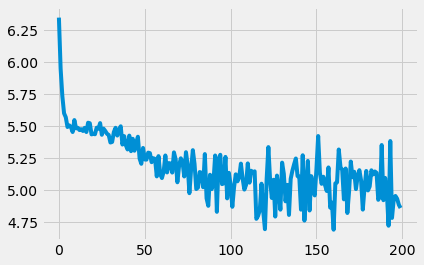

In [256]:
plt.plot(train_loss_per_epoch)

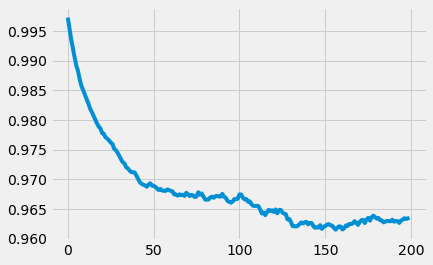

In [257]:
plt.plot(p_history)

In [224]:
max_

798.0